#### Exercise 1
**Task:** *Tune the hyperparameters of the training to beat my best validation loss of 2.2*

In [1]:
words = open('names.txt', 'r').read().split()
alphabet = sorted(list(set([ch for w in words for ch in w])))
stoi = {s: i+1 for i, s in enumerate(alphabet)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [15]:
import torch
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [16]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((40, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [6]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [17]:
lri = []
lossi = []
stepi = []

In [32]:
import torch.nn.functional as F

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  #lr = 0.1 if i < 100000 else 0.01
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.9745581150054932


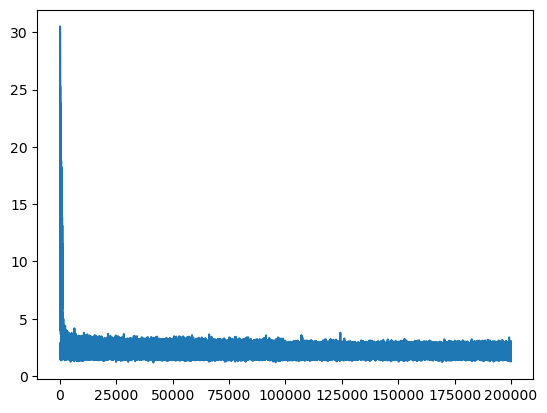

In [31]:
import matplotlib.pyplot as plt

plt.plot(stepi, 10**torch.tensor([lossi]).view(-1))

#### Exercise 2
**Task:** *I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?*

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((40, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

torch.nn.init.xavier_uniform_(C)
torch.nn.init.xavier_uniform_(W1)
torch.nn.init.xavier_uniform_(W2)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [41]:
lri = []
lossi = []
stepi = []

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 4, 10)
  h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  #lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())
# I guess it's lower than with default init

1.9235634803771973


In [43]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0580, grad_fn=<NllLossBackward0>)

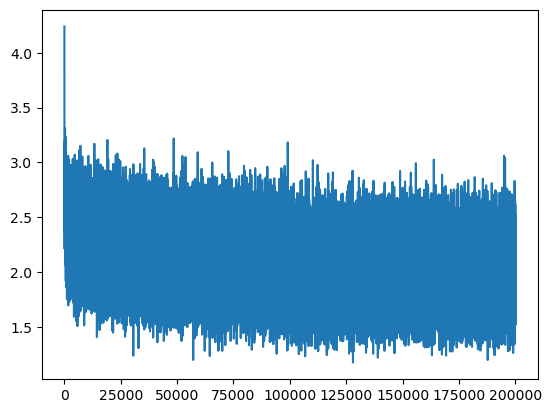

In [42]:
plt.plot(stepi, 10**torch.tensor([lossi]).view(-1))

#### Exercise 3
**Task:** *Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?*